In [1]:
pwd

'/datax2/users/icrar2021/cho134/fdmt-test/SETI tests/Larger Frame Tests'

In [17]:
import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
from astropy import units as u
import cupy as cp
%matplotlib inline

fdmt= Fdmt()

-0.1


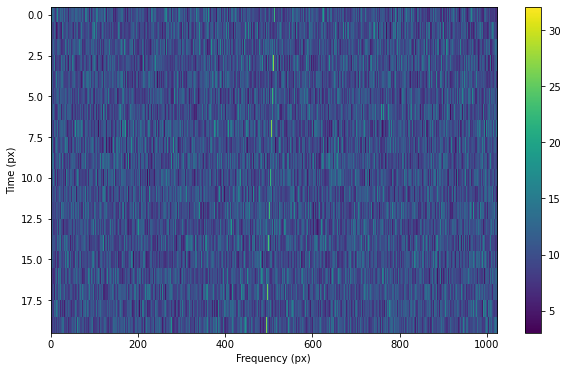

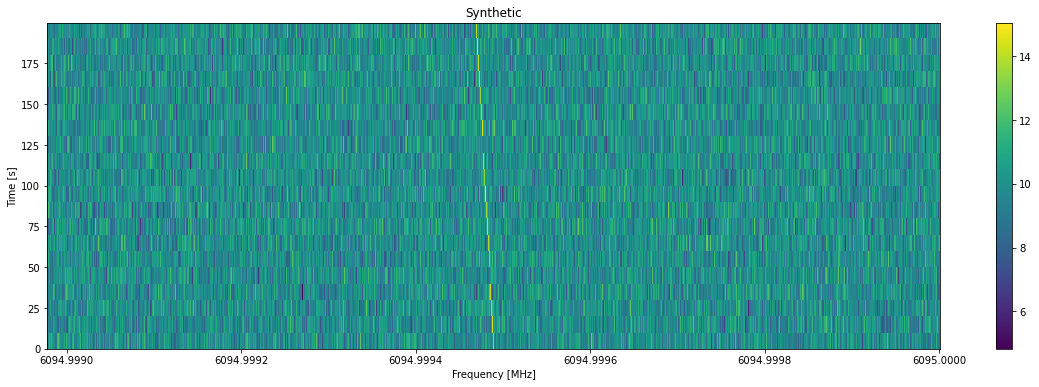

In [23]:


frame = stg.Frame(fchans=1024*u.pixel,
                  tchans=20*u.pixel,
                  df=1*u.Hz,
                  dt=10*u.s,
                  fch1=6095*u.MHz)
noise = frame.add_noise(x_mean=10, noise_type='chi2')
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=frame.fchans/2),
                                            drift_rate=-frame.df/frame.dt),
                          stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                          stg.box_f_profile(width=1*u.Hz),
                          stg.constant_bp_profile(level=1))

#print(frame.get_frequency(frame.fchans)-frame.get_frequency(0))
print(-frame.df/frame.dt)
fig = plt.figure(figsize=(10, 6))
frame.plot()
plt.show()

fig = plt.figure(figsize=(20, 6))
frame.bl_plot()
plt.show()

In [24]:
def ddframecentered(stgframe, negative_delays, exponent):
    
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    print(max_delay)
    #max_delay = max_drift_rate
    gulp_size = 4 * 8192

    d_cpu = np.expand_dims(fr.data, axis=0)
    print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=negative_delays)

    d_out = d_out.copy(space='system')
    
    img = cp.asarray(d_out.squeeze())
    peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    print(peaks)  
    
    #plotting the fdmt
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])
    #, extent=[0, 1024, 0.23, 0]
    plt.xlabel("Frequency")
    plt.ylabel("Dispersion trial")
    plt.colorbar()
    

40
(1, 20, 1024)
[506.8615]


/tmp/ipykernel_22396/3463881091.py:36: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])


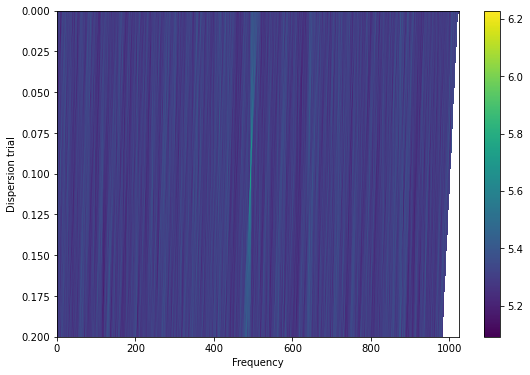

In [26]:
ddframecentered(frame, False, 1)

In [6]:
# from numba import cuda

# cuda.current_context().deallocations.clear()

In [7]:
# for gpu in cuda.gpus:
#     cuda.current_context().deallocations.clear()

In [8]:
import hyperseti
from hyperseti import dedoppler
from hyperseti import plotting 
%matplotlib inline

In [9]:
test_data = np.expand_dims(frame.data.astype('float32'), axis=1)

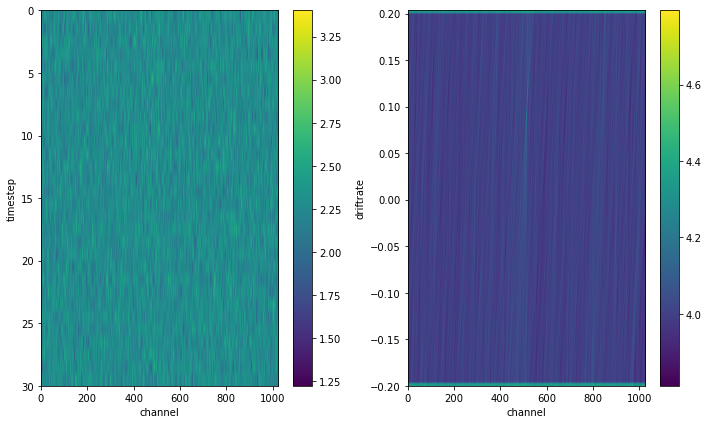

In [10]:

metadata = {'frequency_start': 6095*u.MHz, 'time_step': 10*u.s, 'frequency_step': 1*u.Hz}

# Run dedoppler
dedopp, metadata= dedoppler(test_data, metadata, boxcar_size=1, max_dd=0.2)

# Imshow output
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plotting.imshow_waterfall(np.log(test_data), metadata)
plt.subplot(1,2,2)
plotting.imshow_dedopp(np.log(dedopp), metadata)
plt.tight_layout()

In [11]:
#!cuda-memcheck 'cupy_backends/cuda/api/runtime.pyx' |more

In [12]:
!nvidia-smi

Tue Jan 25 16:32:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:82:00.0 Off |                  N/A |
| 25%   52C    P2    59W / 250W |   3851MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------